In this code we will use a dataset that consists of 698 samples of 4096-dimensional vectors. These vectors are the coded brightness values of 64x64-pixel heads that have been rendered facing various directions and lighted from many angles.

We first transform them either using PCA to reduce their linear dimensionality, or isomap to non-linearly do the same.
We then train a KNeighborsClassifier to identify what direction a face is pointing towards: either up, down, left, or right. 

In [1]:
import random, math
import pandas as pd
import numpy as np
import scipy.io
import os
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
matplotlib.style.use('ggplot') # Look Pretty

In [2]:
# True if test with PCA and False if test with Isomap
Test_PCA = False

In [3]:
def Plot2DBoundary(DTrain, LTrain, DTest, LTest):
 
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('Transformed Boundary, Image Space -> 2D')

    padding = 0.1   # Zoom out
    resolution = 1  # Don't get too detailed; smaller values (finer rez) will take longer to compute
    colors = ['blue','green','orange','red']



    # Calculating the boundaries of the mesh grid.
    x_min, x_max = DTrain[:, 0].min(), DTrain[:, 0].max()
    y_min, y_max = DTrain[:, 1].min(), DTrain[:, 1].max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range * padding
    y_min -= y_range * padding
    x_max += x_range * padding
    y_max += y_range * padding

    # Using the boundaries to make the 2D Grid Matrix
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                       np.arange(y_min, y_max, resolution))


    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    # Uncomment the below two print statements to understand the shape conversion
    #print(Z, Z.shape, xx.shape)
    Z = Z.reshape(xx.shape)
    #print(Z, Z.shape)
    # Plotingt the mesh grid
    plt.contourf(xx, yy, Z, cmap=plt.cm.terrain, z=-100)


    # Sizing the test images as 5% of the overall chart size
    x_size = x_range * 0.05
    y_size = y_range * 0.05

    # Plotting the images in the TEST dataset
    img_num = 0
    for index in LTest.index:
        # DTest is a regular NDArray, so 1 iteration at a time.
        x0, y0 = DTest[img_num,0]-x_size/2., DTest[img_num,1]-y_size/2.
        x1, y1 = DTest[img_num,0]+x_size/2., DTest[img_num,1]+y_size/2.

        # DTest = our images isomap-transformed into 2D. But we still want
        # to plot the original image, so we look to the original, untouched
        # dataset (at index) to get the pixels:
        img = df.iloc[index,:].values.reshape(num_pixels, num_pixels)
        ax.imshow(img, aspect='auto', cmap=plt.cm.gray, interpolation='nearest', zorder=100000, 
                  extent=(x0, x1, y0, y1), alpha=0.8)
        img_num += 1


    # Plotting the TRAINING points
    for label in range(len(np.unique(LTrain))):
        indices = np.where(LTrain == label)
        # Each Ltrain label category gets a unique colour aka one among the four colours
        ax.scatter(DTrain[indices, 0], DTrain[indices, 1], c=colors[label], alpha=0.8, marker='o')

    # Plot
    plt.show()  

In [4]:
#
# Loading up the face_data dataset
mat = scipy.io.loadmat('Datasets\\face_data.mat')
df = pd.DataFrame(mat['images']).T
num_images, num_pixels = df.shape
num_pixels = int(math.sqrt(num_pixels))

In [5]:
# Rotating the pictures
for i in range(num_images):
    df.loc[i,:] = df.loc[i,:].values.reshape(num_pixels, num_pixels).T.reshape(-1)

In [6]:
#
# Loading up the face_labels dataset
temp = pd.read_csv("Datasets\\face_labels.csv", sep=',', header= None)

# Changing the type to series
labels = temp.iloc[:, 0]        
print (type(labels)) 

#print label.head()
print ("Series", len(labels))
print ("Data frame", len(temp))

<class 'pandas.core.series.Series'>
Series 698
Data frame 698


In [7]:
# Splitting the data into training and testing datasets for training and testing accuracy of the model
data_train, data_test, label_train, label_test = train_test_split(df,labels, test_size = 0.15, random_state = 7)

In [8]:
# To perform a comparitive study
if Test_PCA:
    # PCA is used before KNeighbors to simplify the high dimensionality
    # image samples down to just 2 principal components
    pca = PCA(n_components =2)
    pca.fit(data_train)
    data_train = pca.transform(data_train)
    data_test = pca.transform(data_test)
else:
    # Isomap is used before KNeighbors to simplify the high dimensionality
    # image samples down to just 2 components!
    iso = manifold.Isomap(n_components = 2)
    iso.fit(data_train)
    data_train = iso.transform(data_train)
    data_test = iso.transform(data_test)  

Model Accuracy:  0.9619047619047619


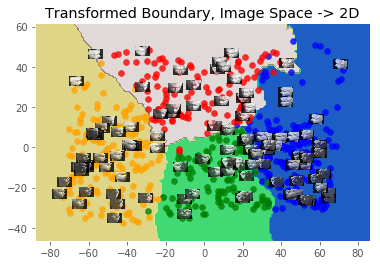

In [9]:
#
# Implementing KNeighborsClassifier here. (Value of K from 1 to 20)
#
model = KNeighborsClassifier(n_neighbors = 5)
model.fit(data_train, label_train)

prediction = model.predict(data_test)
model.predict_proba(data_test)

print("Model Accuracy: ",accuracy_score(label_test, prediction))

Plot2DBoundary(data_train, label_train, data_test, label_test)